<a href="https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/continuum_imaging_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuum Imaging 

This notebook will demonstrate how to create a continuum dirty image with natural weighting using ngCASA. The resulting image will be compared with an image created by CASA. 

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion) and uploaded to the AWS S3 cloud.  This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/continuum_imaging_example.ipynb).


## Installation

- S3Fs is a pythonic file interface to AWS S3 cloud storage (all the needed data is stored here).
- ngcasa is the prototype for the next generation of CASA software.
- cngi-prototype casa next generation infrastructure.


In [0]:
import os
os.system("pip install s3fs")
os.system("pip install ngcasa==0.0.11")
os.system("pip install cngi-prototype==0.0.55")
print("complete")

complete


## Download Data from AWS S3 Cloud


In [6]:
import s3fs
from cngi.dio import write_zarr 
import xarray as xr

# Initialize the S3 "file system"
s3 = s3fs.S3FileSystem(anon=True, requester_pays=False)

# Specify AWS S3 paths
bucket = "cngi-prototype-test-data/"
s3_path = bucket+"test_data/"

if s3.isdir(s3_path): # it's working
    print("AWS S3 Path found")

s3_vis = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"
s3_metadata = s3_path+"sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/global"
s3_casa_image = s3_path+"casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr" #Image created by CASA

# Convert object stores to our desired MutableMapping interface
store_vis = s3fs.S3Map(root=s3_vis, s3=s3, check=False)
store_global = s3fs.S3Map(root=s3_metadata, s3=s3, check=False)
store_casa_image = s3fs.S3Map(root=s3_casa_image, s3=s3, check=False)

# Read zarr files
vis_dataset = xr.open_zarr(store=store_vis,overwrite_encoded_chunks=True)
casa_image_dataset = xr.open_zarr(store=store_casa_image)

#Saving a local copy of the dataset and CASA image
vis_local_store = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"
write_zarr(vis_dataset,vis_local_store)

image_local_store = "casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr"
write_zarr(casa_image_dataset,image_local_store)

print('Finished downloading files')

AWS S3 Path found
Time to store and execute graph  write_zarr 15.459403038024902
Time to store and execute graph  write_zarr 0.39535093307495117
Finished downloading files


## Load Dataset

Two datasets are are needed for this notebook sis14_twhya_field_5_lsrk_pol_xx.vis.zarr and casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr (for more information about the img.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/visibilities.html) and for the vis.zarr format go [here](https://cngi-prototype.readthedocs.io/en/latest/images.html)). 

The sis14_twhya_field_5_lsrk_pol_xx.vis.zarr dataset is used to create a continuum image. The dataset was created by using the ```mstransform``` command in CASA
```python
mstransform('sis14_twhya_calibrated_flagged.ms', outputvis='sis14_twhya_field_5_lsrk_pol_xx.ms', regridms=True, outframe='LSRK',datacolumn='data',correlation='XX',field='5')
```
and then convert_ms in cngi.conversion
```python
infile = 'sis14_twhya_field_5_lsrk_pol_xx.ms'
outfile = 'sis14_twhya_field_5_lsrk_pol_xx.vis.zarr'
chunk_shape=(270, 210, 12, 1)
convert_ms(infile, outfile=outfile , chunk_shape=chunk_shape)
```
The conversion to 'LSRK' is necessary because cngi does not currently have an implementation and tclean does a conversion to 'LSRK' before imaging.

To check the ngcasa imaging results the casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr dataset is used. This dataset was generated by running ```tclean``` in CASA
```python
tclean(vis='sis14_twhya_field_5_lsrk_pol_xx.ms',
imagename='twhya_standard_gridder_lsrk_mfs_natural',
specmode='mfs',
deconvolver='hogbom',
imsize=[200,400],
cell=['0.08arcsec'],
weighting='natural',
threshold='0mJy',
niter=0,stokes='XX')
```
and then ```image_ms``` in cngi.conversion
```python
infile = 'twhya_standard_gridder_lsrk_mfs_natural.image'
outfile = 'casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr'
convert_image(infile=infile,outfile=outfile)
```

In [7]:
import xarray as xr
vis_local_store = "sis14_twhya_field_5_lsrk_pol_xx.vis.zarr/0"
image_local_store = "casa_twhya_standard_gridder_lsrk_mfs_natural.img.zarr"

vis_dataset = xr.open_zarr(store=vis_local_store,chunks={'chan':192})
casa_image_dataset = xr.open_zarr(store=image_local_store)

print(vis_dataset)
print('##############################')
print(casa_image_dataset)
print('complete')

<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pair: 2, pol: 1, receptor: 2, spw: 1, time: 270, uvw_index: 3)
Coordinates:
    antennas        (baseline, pair) int32 dask.array<chunksize=(210, 2), meta=np.ndarray>
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    corr_product    (receptor, pol) int32 dask.array<chunksize=(2, 1), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    field           (time) <U6 dask.array<chunksize=(270,), meta=np.ndarray>
    interval        (time) float64 dask.array<chunksize=(270,), meta=np.ndarray>
    observation     (time) <U22 dask.array<chunksize=(270,), meta=np.ndarray>
  * pol             (pol) int32 9
    processor       (time) <U14 dask.array<chunksize=(270,), meta=np.ndarray>
    resolutio

Note that the chunks parameter in cngi and ngcasa functions specifies the size of a chunk and not the number of chunks (in CASA ```tclean``` chanchunks refers to the number of channel chunks).

The dimensionality of the sis14_twhya_field_5_lsrk_pol_xx.vis.zarr dataset is (time:270,baseline:210,chan:384,pol:1) and a zarr chunk size of (time:270,baseline:210,chan:12,pol:1) was chosen. With the ```xr.open_zarr``` function the dask chunk size was set to (time:270,baseline:210,chan:192,pol:1). For more information concerning chunking go [here](https://ngcasa.readthedocs.io/en/latest/ngcasa_development.html).

## Flag Data and Create Imaging Weights 
The ```applyflags``` cngi.vis function sets all values that should be flagged to nan. The ngcasa.imaging code does not internally apply flags but does ignore nan values. [applyflags documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/cngi.vis.applyflags.html#cngi.vis.applyflags)

The ```make_imaging_weight``` cngi.imaging function takes the WEIGHT or WEIGHT_SPECTRUM data variables and creates IMAGING_WEIGHT data variable that has dimensions time x baseline x chan x pol (matches the visibility DATA variable). Weighting schemes that are supported include natural, uniform, briggs, briggs_abs. [make_imaging_weight documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_imaging_weight.html#ngcasa.imaging.make_imaging_weight)

When ```storage_parms['to_disk']``` is False no execution will occur only a graph will be generated.

In [8]:
from cngi.vis import applyflags
from ngcasa.imaging import make_imaging_weight

vis_dataset_flagged = applyflags(vis_dataset, flags=['FLAG', 'FLAG_ROW'])

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'
imaging_weights_parms['chan_mode'] = 'continuum'
imaging_weights_parms['imsize'] =  [200,400]
imaging_weights_parms['cell'] = [0.08, 0.08]

storage_parms = {}
storage_parms['to_disk'] = False 
vis_dataset_flagged = make_imaging_weight(vis_dataset_flagged, imaging_weights_parms, storage_parms)

######################### Start make_imaging_weights #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default imaging_weight_name  to  IMAGING_WEIGHT
Setting default robust  to  0.5
Setting default graph_name  to  make_imaging_weights
WEIGHT data variable found, will use WEIGHT to calculate  IMAGING_WEIGHT
##################### Created graph for make_imaging_weights #####################


## Create Dirty Continuum Image and Primary Beam
The ```make_image``` cngi.imaging function grids the data (using the prolate spheroidal function as an anti-aliasing filter), fast Fourier transform the gridded data to an image and normalizes the image. The ```make_pb``` function currently supports rotationally symmetric airy disk primary beams. The ```storage_parms['to_disk']``` is now set to True which will trigger a compute (which includes applying the flags, creating the imaging weights and making the image).

[make_pb documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_pb.html#ngcasa.imaging.make_pb)

[make_image documentation](https://ngcasa.readthedocs.io/en/latest/_api/api/ngcasa.imaging.make_image.html)

In [9]:
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
import dask

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['imsize'] =  [200,400]
grid_parms['cell'] = [0.08, 0.08]

storage_parms = {}
storage_parms['to_disk'] =  False

image_dataset = make_image(vis_dataset_flagged,grid_parms,storage_parms)
print(image_dataset)

storage_parms['to_disk'] =  True
storage_parms['outfile'] = 'twhya_standard_gridder_lsrk_mfs_natural.img.zarr'
storage_parms['graph_name'] = 'make_imaging_weights, make_image and make_pb'
    
make_pb_parms = {}
make_pb_parms['function'] = 'airy'
make_pb_parms['cell'] = [0.08,0.08]
make_pb_parms['imsize'] = [200,400]
make_pb_parms['list_dish_diameters'] = [10.7]
make_pb_parms['list_blockage_diameters'] = [0.75]
make_pb_parms['pb_name'] = 'PB'

image_dataset = make_pb(image_dataset,make_pb_parms, storage_parms)

print(image_dataset)

######################### Start make_image #########################
Setting default data_name  to  DATA
Setting default uvw_name  to  UVW
Setting default imaging_weight_name  to  IMAGING_WEIGHT
Setting default image_name  to  DIRTY_IMAGE
Setting default sum_weight_name  to  SUM_WEIGHT
Setting default oversampling  to  100
Setting default support  to  7
Setting default fft_padding  to  1.2
Setting default graph_name  to  make_image
##################### Created graph for make_image #####################
<xarray.Dataset>
Dimensions:      (chan: 1, d0: 200, d1: 400, pol: 1)
Coordinates:
  * d0           (d0) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199
  * d1           (d1) int64 0 1 2 3 4 5 6 7 ... 392 393 394 395 396 397 398 399
  * chan         (chan) float64 3.726e+11
  * pol          (pol) int64 0
    chan_width   (chan) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    SUM_WEIGHT   (chan, pol) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>


## Plot and Compare With CASA

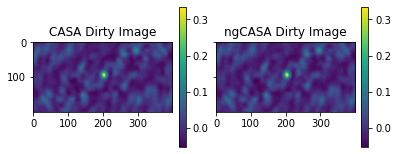

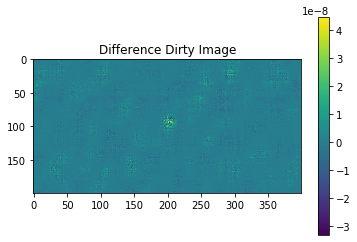

Max Error 1.8390739719986726e-07
RMS Error 2.7024882272917234e-06


In [10]:
import matplotlib.pylab as plt
import numpy as np

#### Compare dirty images ####
dirty_image = image_dataset.DIRTY_IMAGE[:,:,0,0] #Image created by ngCASA
casa_dirty_image = casa_image_dataset['RESIDUAL'].values[:, :, 0, 0] #Image created by CASA
    
#Plotting Images
fig0, ax0 = plt.subplots(1, 2, sharey=True)
im0 = ax0[0].imshow(casa_dirty_image)
im1 = ax0[1].imshow(dirty_image)
ax0[0].title.set_text('CASA Dirty Image')
ax0[1].title.set_text('ngCASA Dirty Image')
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
plt.show()
        
plt.figure()
plt.imshow(casa_dirty_image - dirty_image)
plt.title('Difference Dirty Image')
plt.colorbar()
plt.show()
    
dirty_image = dirty_image / np.max(np.abs(dirty_image))
casa_dirty_image = casa_dirty_image / np.max(np.abs(casa_dirty_image))

# Calculate max error
max_error_dirty_image = np.max(np.abs(dirty_image - casa_dirty_image)).values
print('Max Error',max_error_dirty_image)

# Calculate root mean square error
rms_error_dirty_image = np.linalg.norm(dirty_image - casa_dirty_image, 'fro')
print('RMS Error',rms_error_dirty_image)

The reason for the small difference between ngCASA and CASA is due to ngCASA using a different implementation of the Fast Fourier Transform. 

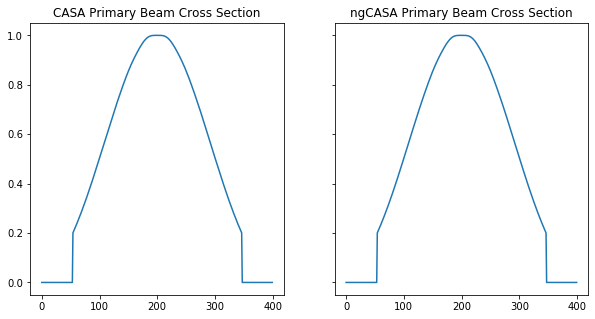

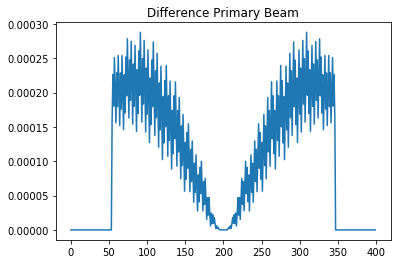

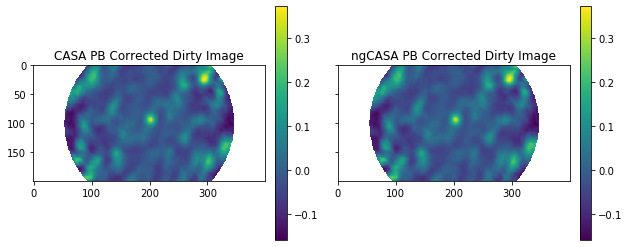

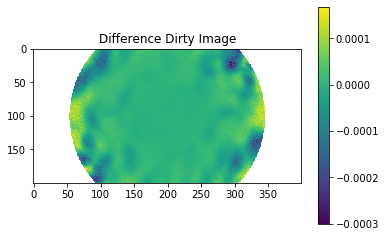

Max Normalized Error 0.0005570761354674048
RMS Normalized Error 0.011388274342681696


In [11]:
import matplotlib.pylab as plt
import numpy as np
import xarray as xr
import dask.array as da
import dask

#### Primary Beam Corrected Images ####
pb_limit = 0.2
primary_beam = image_dataset.PB[100,:,0,0,0].where(image_dataset.PB[100,:,0,0,0] > pb_limit,other=0.0)
dirty_image_pb_cor = image_dataset.DIRTY_IMAGE[:,:,0,0]/image_dataset.PB[:,:,0,0,0]
dirty_image_pb_cor = dirty_image_pb_cor.where(image_dataset.PB[:,:,0,0,0] > pb_limit,other=np.nan)

casa_primary_beam = casa_image_dataset['PB'][100, :, 0, 0] #Primary beam created by CASA
casa_dirty_image_pb_cor = (casa_image_dataset['IMAGE.PBCOR'][:, :, 0, 0]).where(casa_image_dataset['PB'][:, :, 0, 0] > pb_limit,other=np.nan) #Image created by CASA

#Plot Primary Beams
fig0, ax0, = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
im0 = ax0[0].plot(casa_primary_beam)
im1 = ax0[1].plot(primary_beam)
ax0[0].title.set_text('CASA Primary Beam Cross Section')
ax0[1].title.set_text('ngCASA Primary Beam Cross Section')
plt.show()

plt.figure()
plt.plot(casa_primary_beam-primary_beam)
plt.title('Difference Primary Beam')
plt.show()

#Plotting Images
fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
im0 = ax0[0].imshow(casa_dirty_image_pb_cor)
im1 = ax0[1].imshow(dirty_image_pb_cor)
ax0[0].title.set_text('CASA PB Corrected Dirty Image')
ax0[1].title.set_text('ngCASA PB Corrected Dirty Image')
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
plt.show()
 
plt.figure()
plt.imshow(casa_dirty_image_pb_cor - dirty_image_pb_cor)
plt.title('Difference Dirty Image')
plt.colorbar()
plt.show()

dirty_image_pb_cor = dirty_image_pb_cor / np.nanmax(np.abs(dirty_image_pb_cor))
casa_dirty_image_pb_cor = casa_dirty_image_pb_cor / np.nanmax(np.abs(casa_dirty_image_pb_cor))
norm_diff_image_pb_cor = dirty_image_pb_cor - casa_dirty_image_pb_cor

# Calculate max error
max_error_dirty_image = np.nanmax(np.abs(norm_diff_image_pb_cor))
print('Max Normalized Error',max_error_dirty_image)

# Calculate root mean square error
rms_error_dirty_image = np.sqrt(np.nansum(np.square(norm_diff_image_pb_cor)))
print('RMS Normalized Error',rms_error_dirty_image)


The difference in primary beam is due to CASA using a sampled 1D function while ngCASA calculates the PB for each pixel. If it is found that PB creation becomes a bottleneck for ngCASA the implementation will be changed to match CASA.

## Execute this Notebook in Colab


https://colab.research.google.com/github/casangi/ngcasa/blob/master/docs/prototypes/continuum_imaging_example.ipynb